In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

In [2]:
# Cyclical stocks
cyclical_stocks = {
    "AMZN": "Amazon", "NKE": "Nike", "SBUX": "Starbucks", "HD": "Home Depot", "GM": "General Motors",
    "JPM": "JPMorgan Chase", "BAC": "Bank of America", "GS": "Goldman Sachs", "WFC": "Wells Fargo", "AXP": "American Express",
    "CAT": "Caterpillar", "BA": "Boeing", "UNP": "Union Pacific", "HON": "Honeywell", "MMM": "3M",
    "DOW": "Dow Inc.", "FCX": "Freeport-McMoRan", "NEM": "Newmont", "LYB": "LyondellBasell", "IP": "International Paper"
}

# Defensive stocks
defensive_stocks = {
    "PG": "Procter & Gamble", "KO": "Coca-Cola", "PEP": "PepsiCo", "CL": "Colgate-Palmolive", "WMT": "Walmart",
    "NEE": "NextEra Energy", "DUK": "Duke Energy", "SO": "Southern Company", "D": "Dominion Energy", "AEP": "American Electric Power",
    "JNJ": "Johnson & Johnson", "PFE": "Pfizer", "MRK": "Merck", "UNH": "UnitedHealth Group", "ABT": "Abbott Laboratories",
    "O": "Realty Income", "SPG": "Simon Property Group", "PSA": "Public Storage", "WELL": "Welltower", "DLR": "Digital Realty"
}

# Cyclical stocks sector map
cyclical_sector_map = {
    "AMZN": "Consumer Discretionary", "NKE": "Consumer Discretionary", "SBUX": "Consumer Discretionary", 
    "HD": "Consumer Discretionary", "GM": "Consumer Discretionary",
    "JPM": "Financials", "BAC": "Financials", "GS": "Financials", "WFC": "Financials", "AXP": "Financials",
    "CAT": "Industrials", "BA": "Industrials", "UNP": "Industrials", "HON": "Industrials", "MMM": "Industrials",
    "DOW": "Materials", "FCX": "Materials", "NEM": "Materials", "LYB": "Materials", "IP": "Materials"
}

# Defensive stocks sector map
defensive_sector_map = {
    "PG": "Consumer Staples", "KO": "Consumer Staples", "PEP": "Consumer Staples", 
    "CL": "Consumer Staples", "WMT": "Consumer Staples",
    "NEE": "Utilities", "DUK": "Utilities", "SO": "Utilities", "D": "Utilities", "AEP": "Utilities",
    "JNJ": "Healthcare", "PFE": "Healthcare", "MRK": "Healthcare", "UNH": "Healthcare", "ABT": "Healthcare",
    "O": "Real Estate", "SPG": "Real Estate", "PSA": "Real Estate", "WELL": "Real Estate", "DLR": "Real Estate"
}


In [3]:
import yfinance as yf
import pandas as pd

# Function to download data (much faster than manually downloading)
def download_stock_data(stock_dict, interval='1wk'):
    df = pd.DataFrame()
    for ticker in stock_dict.keys():
        stock_data = yf.download(ticker, period="5y", interval=interval)  # 5 years of weekly data
        if 'Close' in stock_data.columns:
            df[ticker] = stock_data['Close']
    return df

cyclical_df = download_stock_data(cyclical_stocks)
defensive_df = download_stock_data(defensive_stocks)

cyclical_df.index = pd.to_datetime(cyclical_df.index)
defensive_df.index = pd.to_datetime(defensive_df.index)

cyclical_dates = cyclical_df.index
defensive_dates = defensive_df.index

cyclical_df.index = cyclical_dates
defensive_df.index = defensive_dates


# Display the first few rows
print("Cyclical Portfolio Data:")
display(cyclical_df.head())

print("\nDefensive Portfolio Data:")
display(defensive_df.head())

print("\nDimensions of Cyclical Portfolio Data:", cyclical_df.shape)
print("\nDimensions of Defensive Portfolio Data:", defensive_df.shape)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Cyclical Portfolio Data:


AMZN        NKE       SBUX          HD         GM  \
Date                                                                  
2020-04-06  102.138000  81.752716  66.344986  178.715195  23.394625   
2020-04-13  118.750000  84.691650  69.236572  185.711945  21.858318   
2020-04-20  120.511002  83.241051  67.871613  188.159500  21.342976   
2020-04-27  114.302002  80.575294  66.264168  193.826141  20.322014   
2020-05-04  118.980499  85.209740  69.928062  207.890640  23.268223   

                  JPM        BAC          GS        WFC        AXP  \
Date                                                                 
2020-04-06  89.417953  21.954861  163.222977  29.229292  88.815514   
2020-04-13  82.822128  20.559490  162.540863  24.985769  81.856018   
2020-04-20  78.932472  19.588037  156.791840  23.700386  77.903252   
2020-04-27  81.142708  20.382868  156.880447  24.290249  82.727135   
2020-05-04  80.664101  20.815607  164.223953  22.388588  83.832413   

                   CAT          BA         UNP         HON         MMM  \
Date                                                                     
2020-04-06  112.406136  151.839996  133.356812  129.342010  101.365135   
2020-04-13  104.557571  154.000000  134.396881  124.733887  100.459724   
2020-04-20  103.467033  128.979996  139.956055  122.208916  100.830101   
2020-04-27  100.599991  133.369995  140.449203  123.768997  101.927597   
2020-05-04  101.715958  133.440002  141.901733  123.462387  101.865852   

                  DOW       FCX        NEM        LYB         IP  
Date                                                              
2020-04-06  28.081253  7.752494  48.750965  43.393475  25.830070  
2020-04-13  25.669460  7.894481  50.384216  38.430435  24.076317  
2020-04-20  25.439034  8.027003  53.684750  36.854633  23.532043  
2020-04-27  26.061184  8.008073  51.881371  40.617409  25.633522  
2020-05-04  26.368422  8.718006  54.909695  41.567314  25.966131


Defensive Portfolio Data:


PG         KO         PEP         CL        WMT  \
Date                                                                  
2020-04-06  101.331169  42.022682  115.497757  62.194557  37.730103   
2020-04-13  110.195236  41.216541  118.885857  65.317200  40.926933   
2020-04-20  104.972252  38.961025  116.128708  63.906151  40.096741   
2020-04-27  103.928596  39.106815  112.481331  61.337383  38.077045   
2020-05-04  103.154587  39.544209  116.016365  62.089218  38.083233   

                  NEE        DUK         SO          D        AEP         JNJ  \
Date                                                                            
2020-04-06  54.355904  73.737160  49.480083  65.752136  71.842735  122.739517   
2020-04-13  54.573078  73.565704  47.134426  65.687660  71.901024  132.116867   
2020-04-20  53.119339  69.964981  47.347656  62.794548  69.278992  134.585068   
2020-04-27  50.315998  67.474693  44.624744  60.932938  67.747429  128.875229   
2020-05-04  50.909901  66.772507  45.444897  63.181362  66.473862  129.231567   

                  PFE        MRK         UNH        ABT          O        SPG  \
Date                                                                            
2020-04-06  26.937490  67.513351  245.429413  78.777443  42.972538  51.376572   
2020-04-13  28.094458  68.307236  269.988129  87.905907  39.704865  42.295040   
2020-04-20  28.452206  66.645798  270.666473  86.483147  37.847378  38.805626   
2020-04-27  28.650101  63.568459  264.366486  82.612274  39.265148  47.630905   
2020-05-04  28.330421  62.529034  266.680176  86.152168  41.768784  43.726990   

                   PSA       WELL         DLR  
Date                                           
2020-04-06  168.767319  48.352875  124.375389  
2020-04-13  158.969299  41.945698  125.138641  
2020-04-20  151.485229  37.640068  125.834763  
2020-04-27  149.163177  40.433601  122.387589  
2020-05-04  154.001465  38.058666  121.666290


Dimensions of Cyclical Portfolio Data: (262, 20)

Dimensions of Defensive Portfolio Data: (262, 20)


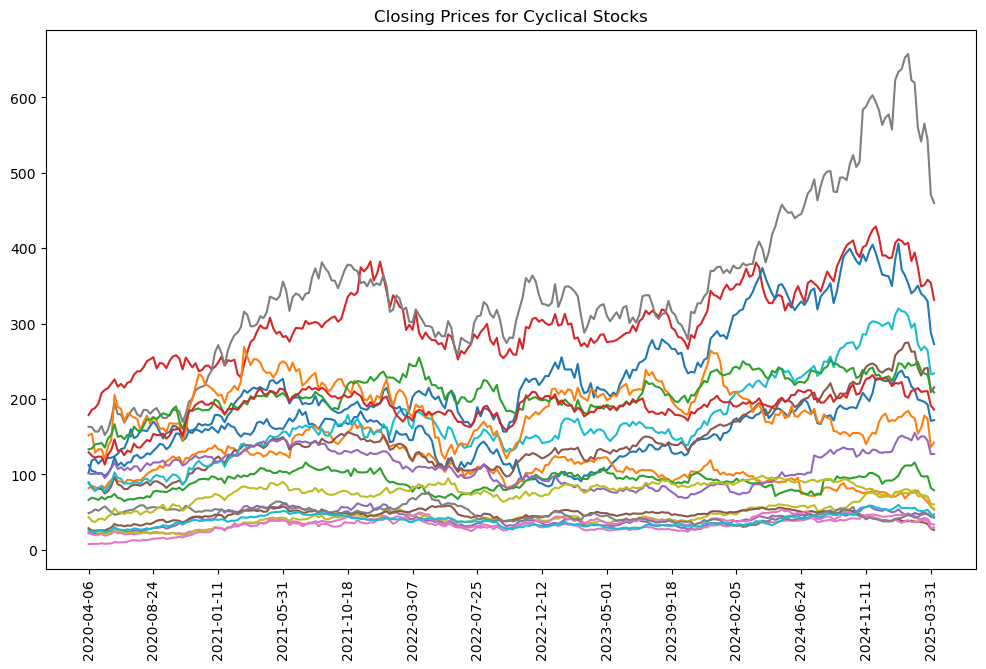

In [4]:
# Plot the cyclical stocks
plt.figure(figsize=(12, 7))
plt.plot(cyclical_df)
plt.xlabel('')
_ = plt.xticks(cyclical_dates[np.arange(0, len(cyclical_dates), 20)], rotation=90)
plt.title('Closing Prices for Cyclical Stocks')
plt.show()

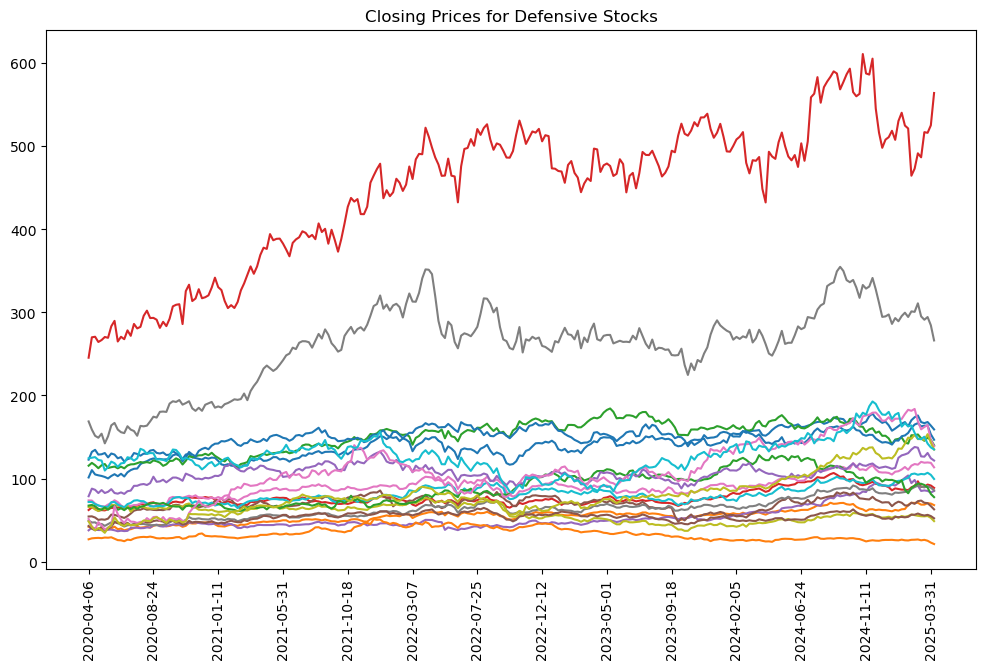

In [5]:
# Plot the cyclical stocks
plt.figure(figsize=(12, 7))
plt.plot(defensive_df)
plt.xlabel('')
_ = plt.xticks(defensive_dates[np.arange(0, len(cyclical_dates), 20)], rotation=90)
plt.title('Closing Prices for Defensive Stocks') 
plt.show()

In [6]:
# Transform the data to log-returns for cylical stocks

df_cylical_log_returns = np.log1p(cyclical_df.pct_change()).iloc[1:]
df_cylical_log_returns

AMZN       NKE      SBUX        HD        GM       JPM  \
Date                                                                     
2020-04-13  0.150696  0.035318  0.042661  0.038403 -0.067925 -0.076626   
2020-04-20  0.014721 -0.017276 -0.019911  0.013093 -0.023859 -0.048103   
2020-04-27 -0.052897 -0.032549 -0.023969  0.029672 -0.049018  0.027617   
2020-05-04  0.040116  0.055924  0.053818  0.070051  0.135384 -0.005916   
2020-05-11  0.012599 -0.039115 -0.043181  0.020686 -0.055857 -0.076185   
...              ...       ...       ...       ...       ...       ...   
2025-03-10 -0.006546 -0.087263 -0.081868 -0.070046  0.021339 -0.041462   
2025-03-17 -0.008829 -0.053308 -0.010657  0.005871  0.029756  0.038776   
2025-03-24 -0.017947 -0.070898  0.006776  0.019738 -0.064699  0.005036   
2025-03-31 -0.119575 -0.100300 -0.174271 -0.011938 -0.055044 -0.144004   
2025-04-07  0.005482 -0.070835 -0.039884 -0.065915 -0.038063  0.030429   

                 BAC        GS       WFC       AXP       CAT        BA  \
Date                                                                     
2020-04-13 -0.065666 -0.004188 -0.156865 -0.081600 -0.072381  0.014125   
2020-04-20 -0.048404 -0.036010 -0.052815 -0.049494 -0.010485 -0.177295   
2020-04-27  0.039776  0.000565  0.024584  0.060080 -0.028101  0.033470   
2020-05-04  0.021008  0.045747 -0.081524  0.013272  0.011032  0.000525   
2020-05-11 -0.094716 -0.075723 -0.064789 -0.084840 -0.038090 -0.106160   
...              ...       ...       ...       ...       ...       ...   
2025-03-10 -0.006105 -0.033170 -0.002819 -0.028136 -0.030904  0.048302   
2025-03-17  0.037912  0.042897  0.023297  0.018205 -0.011430  0.095979   
2025-03-24 -0.029147 -0.039743 -0.025558 -0.018769 -0.018303 -0.027319   
2025-03-31 -0.181885 -0.142876 -0.147758 -0.127587 -0.134915 -0.238098   
2025-04-07 -0.021307 -0.023690 -0.011546  0.004661 -0.054903  0.040462   

                 UNP       HON       MMM       DOW       FCX       NEM  \
Date                                                                     
2020-04-13  0.007769 -0.036278 -0.008972 -0.089800  0.018149  0.032953   
2020-04-20  0.040531 -0.020451  0.003680 -0.009017  0.016647  0.063451   
2020-04-27  0.003517  0.012685  0.010826  0.024162 -0.002361 -0.034169   
2020-05-04  0.010289 -0.002480 -0.000606  0.011720  0.084940  0.056730   
2020-05-11 -0.045371 -0.087735 -0.068411 -0.022685 -0.082579  0.050596   
...              ...       ...       ...       ...       ...       ...   
2025-03-10 -0.048403 -0.023822  0.027706 -0.012900  0.050413  0.058534   
2025-03-17 -0.015486  0.003098 -0.000333 -0.021877  0.035402  0.023933   
2025-03-24 -0.007424  0.001046 -0.037403 -0.051337 -0.046532  0.015088   
2025-03-31 -0.084872 -0.096504 -0.132151 -0.197571 -0.276123 -0.084594   
2025-04-07 -0.021327 -0.025883  0.001221 -0.067474  0.017007  0.061024   

                 LYB        IP  
Date                            
2020-04-13 -0.121459 -0.070311  
2020-04-20 -0.041868 -0.022866  
2020-04-27  0.097215  0.085538  
2020-05-04  0.023117  0.012892  
2020-05-11 -0.051806 -0.101003  
...              ...       ...  
2025-03-10 -0.044188 -0.017164  
2025-03-17 -0.018252 -0.000389  
2025-03-24 -0.024476  0.034803  
2025-03-31 -0.185822 -0.103462  
2025-04-07 -0.069449 -0.091265  

[261 rows x 20 columns]

In [7]:
# Transform the data to log-returns for defensive stocks

df_defensive_log_returns = np.log1p(defensive_df.pct_change()).iloc[1:]
df_defensive_log_returns

PG        KO       PEP        CL       WMT       NEE  \
Date                                                                     
2020-04-13  0.083860 -0.019370  0.028913  0.048988  0.081330  0.003987   
2020-04-20 -0.048558 -0.056278 -0.023465 -0.021840 -0.020493 -0.027000   
2020-04-27 -0.009992  0.003735 -0.031912 -0.041026 -0.051683 -0.054218   
2020-05-04 -0.007475  0.011122  0.030944  0.012183  0.000162  0.011734   
2020-05-11 -0.011624 -0.063801  0.012732 -0.006073  0.028498 -0.008217   
...              ...       ...       ...       ...       ...       ...   
2025-03-10 -0.046414 -0.032295 -0.029812 -0.074219 -0.071980  0.009838   
2025-03-17 -0.007650  0.000242 -0.021358  0.005330  0.007354 -0.036977   
2025-03-24  0.008007  0.024455  0.025924  0.027525 -0.006958 -0.006085   
2025-03-31 -0.025802 -0.006272 -0.017981 -0.012576 -0.023287 -0.051555   
2025-04-07 -0.028557 -0.027252 -0.044920 -0.031362  0.022935 -0.060801   

                 DUK        SO         D       AEP       JNJ       PFE  \
Date                                                                     
2020-04-13 -0.002328 -0.048567 -0.000981  0.000811  0.073623  0.042053   
2020-04-20 -0.050184  0.004514 -0.045043 -0.037149  0.018510  0.012653   
2020-04-27 -0.036242 -0.059229 -0.030094 -0.022355 -0.043352  0.006931   
2020-05-04 -0.010461  0.018212  0.036235 -0.018978  0.002761 -0.011221   
2020-05-11 -0.007241 -0.053185 -0.002298 -0.009148  0.011633  0.024321   
...              ...       ...       ...       ...       ...       ...   
2025-03-10  0.028542 -0.011223 -0.009827  0.008945 -0.023552 -0.038518   
2025-03-17 -0.008528 -0.011350 -0.002380 -0.004272  0.005024  0.021539   
2025-03-24  0.002600  0.019614  0.008034  0.017447  0.000489 -0.041568   
2025-03-31 -0.004028 -0.024325 -0.041967 -0.023459 -0.066091 -0.093052   
2025-04-07 -0.046468 -0.035011 -0.077454 -0.048738 -0.043343 -0.077832   

                 MRK       UNH       ABT         O       SPG       PSA  \
Date                                                                     
2020-04-13  0.011690  0.095369  0.109640 -0.079088 -0.194512 -0.059810   
2020-04-20 -0.024624  0.002509 -0.016317 -0.047912 -0.086105 -0.048223   
2020-04-27 -0.047275 -0.023551 -0.045791  0.036776  0.204917 -0.015447   
2020-05-04 -0.016486  0.008714  0.041957  0.061812 -0.085516  0.031921   
2020-05-11  0.043290  0.013704 -0.041512 -0.092962 -0.122707 -0.078498   
...              ...       ...       ...       ...       ...       ...   
2025-03-10 -0.000846 -0.009836 -0.079101 -0.026377 -0.059540 -0.051800   
2025-03-17 -0.015559  0.060371 -0.002924 -0.015824  0.017855 -0.013790   
2025-03-24 -0.033962 -0.001568  0.034846  0.014412  0.013359  0.011033   
2025-03-31 -0.090982  0.017309 -0.049999 -0.026129 -0.117623 -0.033999   
2025-04-07 -0.047894  0.071463 -0.022347 -0.049848 -0.050087 -0.066572   

                WELL       DLR  
Date                            
2020-04-13 -0.142150  0.006118  
2020-04-20 -0.108307  0.005547  
2020-04-27  0.071592 -0.027777  
2020-05-04 -0.060532 -0.005911  
2020-05-11 -0.091613 -0.103708  
...              ...       ...  
2025-03-10  0.002641 -0.004030  
2025-03-17 -0.008969  0.020504  
2025-03-24  0.046017 -0.056634  
2025-03-31 -0.068309 -0.032907  
2025-04-07 -0.060189 -0.017942  

[261 rows x 20 columns]

Text(0.5, 1.0, 'Log-Returns for Cyclical Stocks')

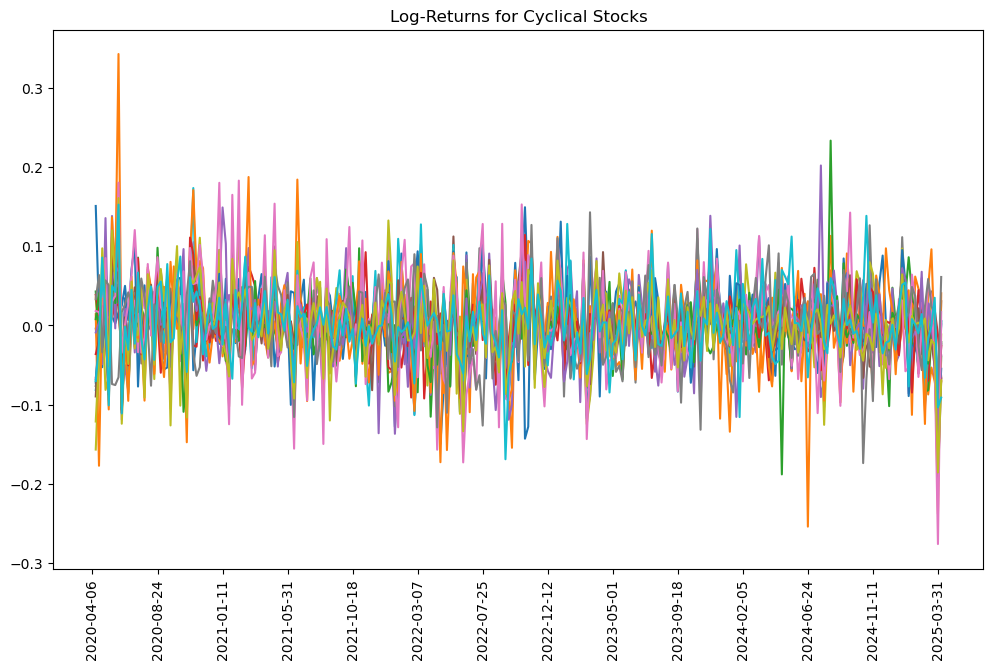

In [8]:
# Plot the transformed cyclical stocks

plt.figure(figsize=(12, 7))
plt.plot(df_cylical_log_returns)
plt.xlabel('')
_ = plt.xticks(cyclical_dates[np.arange(0, len(cyclical_dates), 20)], rotation=90)
plt.title('Log-Returns for Cyclical Stocks')

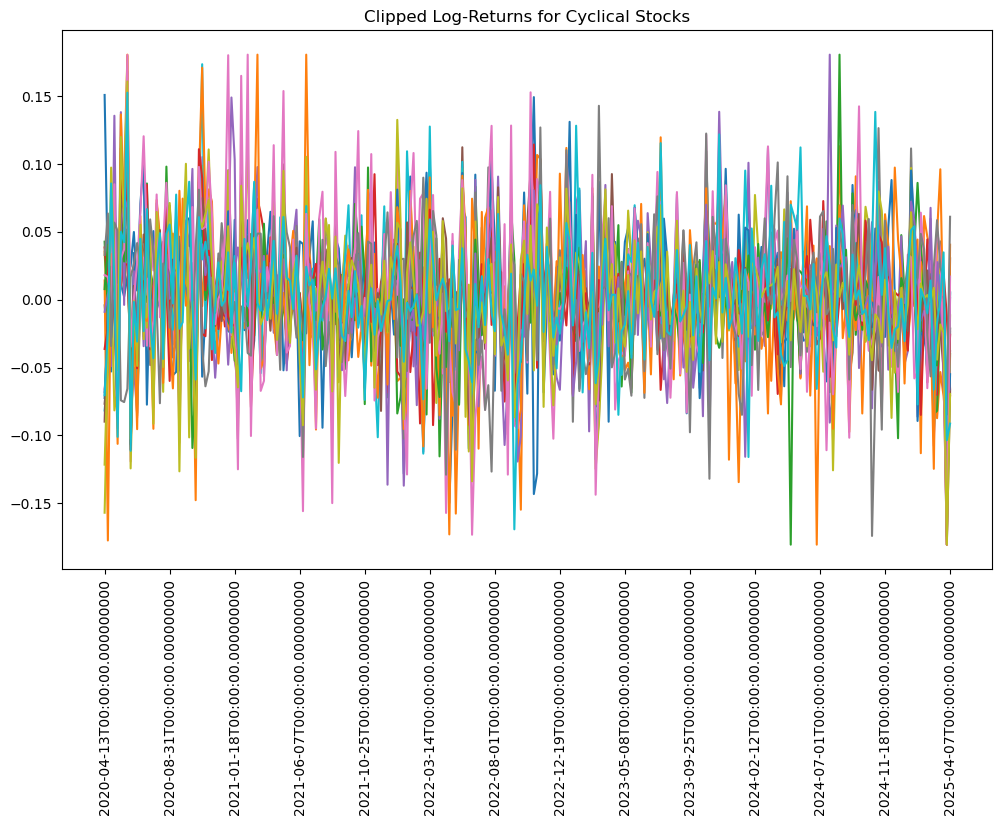

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate log-returns and convert to numpy array (skip the first row to avoid NaN)
cylical_log_returns = np.array(np.log1p(cyclical_df.pct_change()).iloc[1:])

# Define the clipping threshold based on the numpy array
std_dev = 4 * np.std(cylical_log_returns)

# Clip the log returns array
clipped_cylical_log_returns = np.clip(cylical_log_returns, -std_dev, std_dev)

# Plot the clipped log returns
plt.figure(figsize=(12, 7))
plt.plot(clipped_cylical_log_returns)
plt.xlabel('')
plt.xticks(ticks=np.arange(0, len(cyclical_dates[1:]), 20), labels=np.array(cyclical_dates[1:])[np.arange(0, len(cyclical_dates[1:]), 20)], rotation=90)
plt.title('Clipped Log-Returns for Cyclical Stocks')
plt.show()

Text(0.5, 1.0, 'Log-Returns for Defensive Stocks')

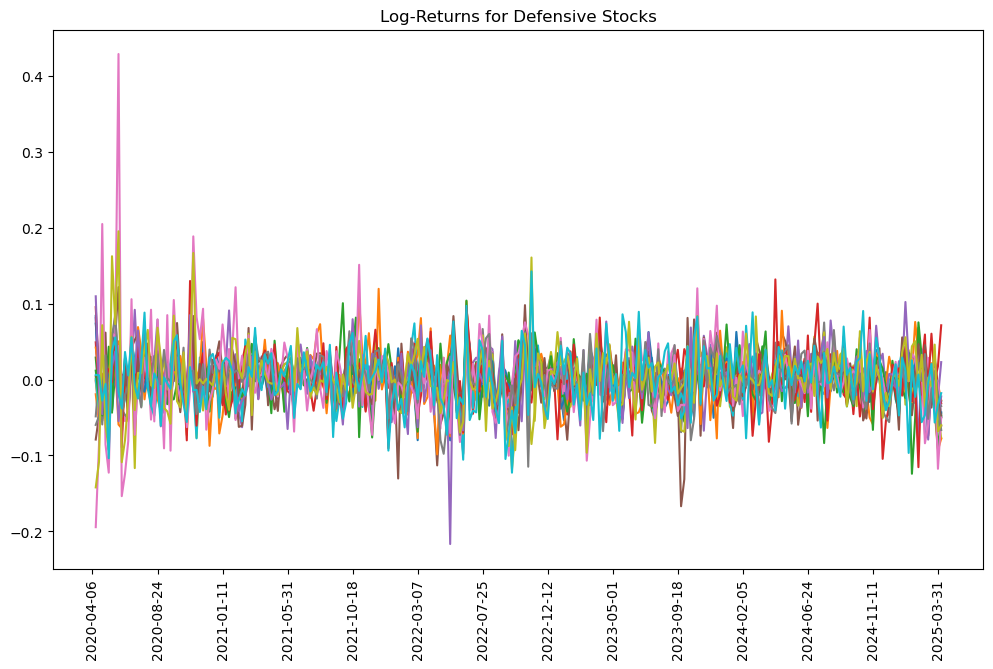

In [10]:
# Plot the transformed defensive stocks

plt.figure(figsize=(12, 7))
plt.plot(df_defensive_log_returns)
plt.xlabel('')
_ = plt.xticks(defensive_dates[np.arange(0, len(defensive_dates), 20)], rotation=90)
plt.title('Log-Returns for Defensive Stocks') 

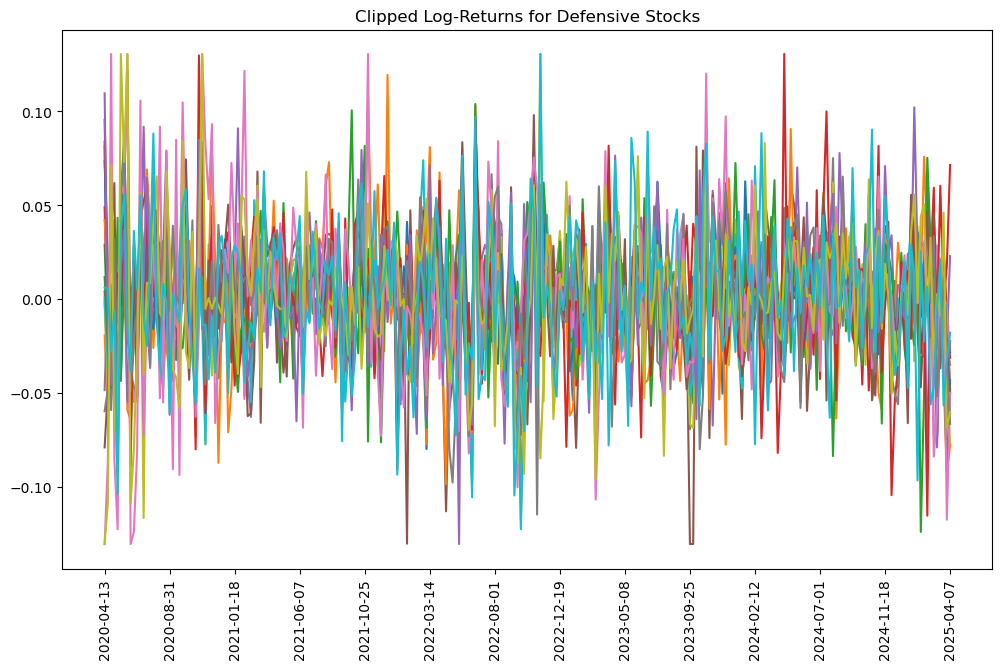

In [11]:
# Clip the log-returns for defensive stocks

defensive_log_returns = np.array(np.log1p(defensive_df.pct_change()).iloc[1:])

std_dev_defensive = 4 * np.std(defensive_log_returns)

clipped_defensive_log_returns = np.clip(defensive_log_returns, -std_dev_defensive, std_dev_defensive)

plt.figure(figsize=(12, 7))
plt.plot(clipped_defensive_log_returns)
plt.xlabel('')
plt.xticks(ticks=np.arange(0, len(defensive_dates[1:]), 20), 
           labels=[date.strftime('%Y-%m-%d') for date in defensive_dates[1:]][::20], 
           rotation=90)
plt.title('Clipped Log-Returns for Defensive Stocks') 
plt.show()

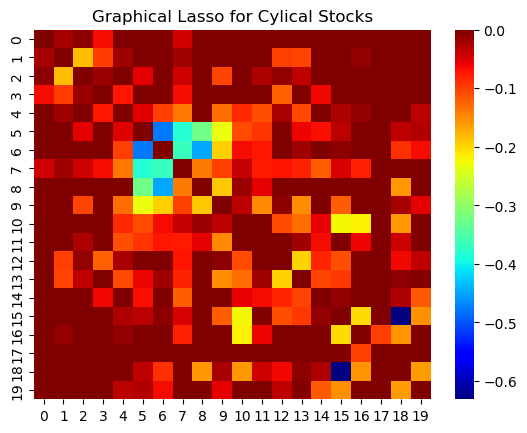

In [12]:
# Run the Graphical Lasso for Cylical Stocks

from sklearn.covariance import GraphicalLasso
import seaborn as sns
import networkx as nx

X1 = np.array(clipped_cylical_log_returns)
p1 = X1.shape[1]
X1 = (X1 - np.mean(X1, axis=0)) / np.std(X1, axis=0)
glasso1 = GraphicalLasso(alpha=.3).fit(X1)
Omeghat1 = np.around(glasso1.precision_, decimals=5)

for j in np.arange(p1): 
    Omeghat1[j,j] = 0
sns.heatmap(Omeghat1, cmap='jet')
plt.title('Graphical Lasso for Cylical Stocks')
plt.show()

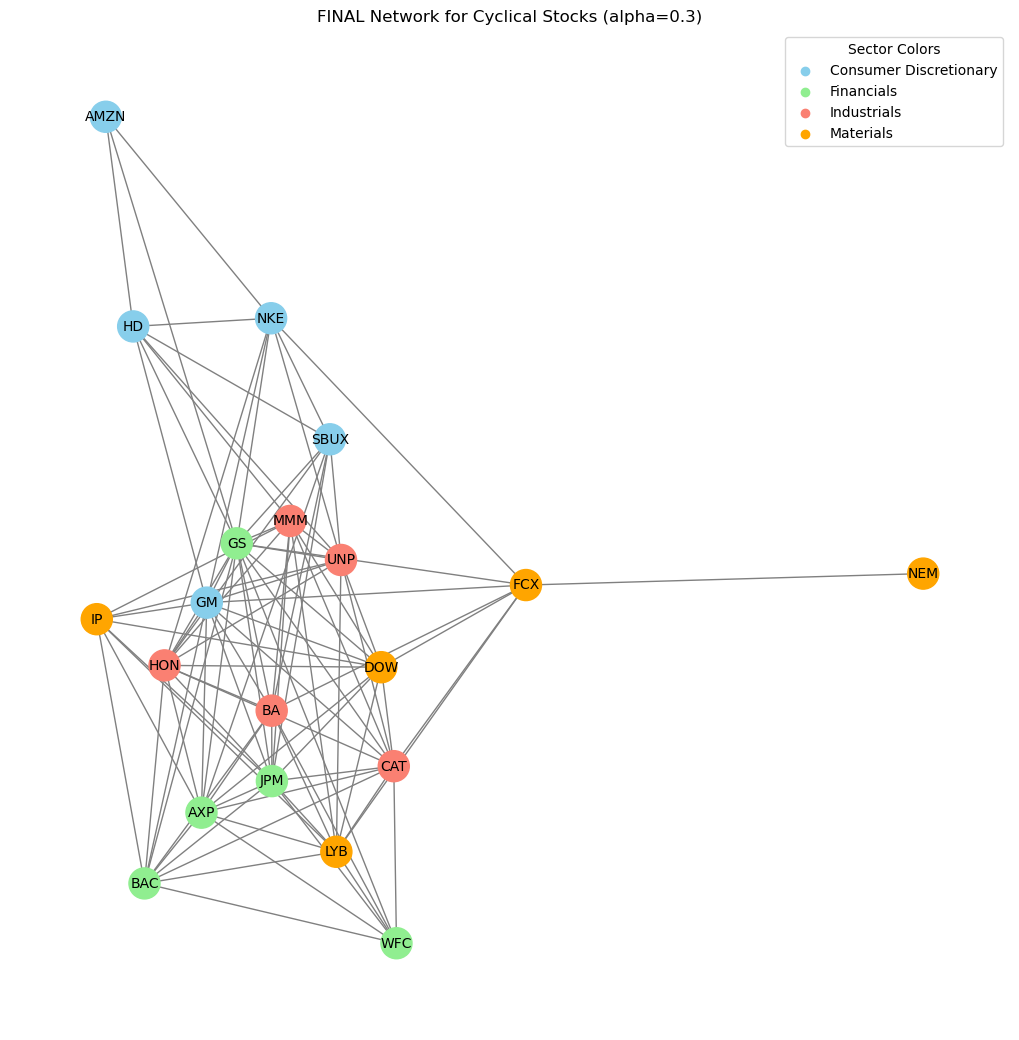

In [13]:
# Run the Graphical Lasso for Cylical Stocks
np.random.seed(42)

sector_colors1 = {
    "Consumer Discretionary": "skyblue",
    "Financials": "lightgreen",
    "Industrials": "salmon",
    "Materials": "orange"
}

# Use stock symbols as node labels
cylical_stocks_names = list(cyclical_stocks.keys())  
precdf1 = pd.DataFrame(Omeghat1, columns=cylical_stocks_names, index=cylical_stocks_names)

# Generate the links for the edges
links1 = precdf1.stack().reset_index()
links1.columns = ['var1', 'var2', 'value']
links1 = links1.loc[(abs(links1['value']) > 0.01) & (links1['var1'] != links1['var2'])]

# Build the graph using stock symbols
G1 = nx.from_pandas_edgelist(links1, 'var1', 'var2', create_using=nx.Graph())
pos1 = nx.spring_layout(G1, k=1.7/np.sqrt(len(G1.nodes())), iterations=20)

# Set colors for each node based on sector
node_colors1 = [sector_colors1[cyclical_sector_map[node]] for node in G1.nodes]

# Visualize the Network for Cyclical Stocks with Colored Nodes
plt.figure(figsize=(10, 10))
nx.draw(G1, pos=pos1, node_color=node_colors1, with_labels=False, node_size=500, edge_color="gray")
nx.draw_networkx_labels(G1, pos=pos1, font_size=10)
plt.title('FINAL Network for Cyclical Stocks (alpha=0.3)')
for sector, color in sector_colors1.items():
    plt.scatter([], [], color=color, label=sector)
plt.legend(loc="upper right", title="Sector Colors")
plt.show()


/var/folders/bf/76shnqyj7qz2pkgp1kh6r2hh0000gn/T/ipykernel_81055/2412517768.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20, seed=42)


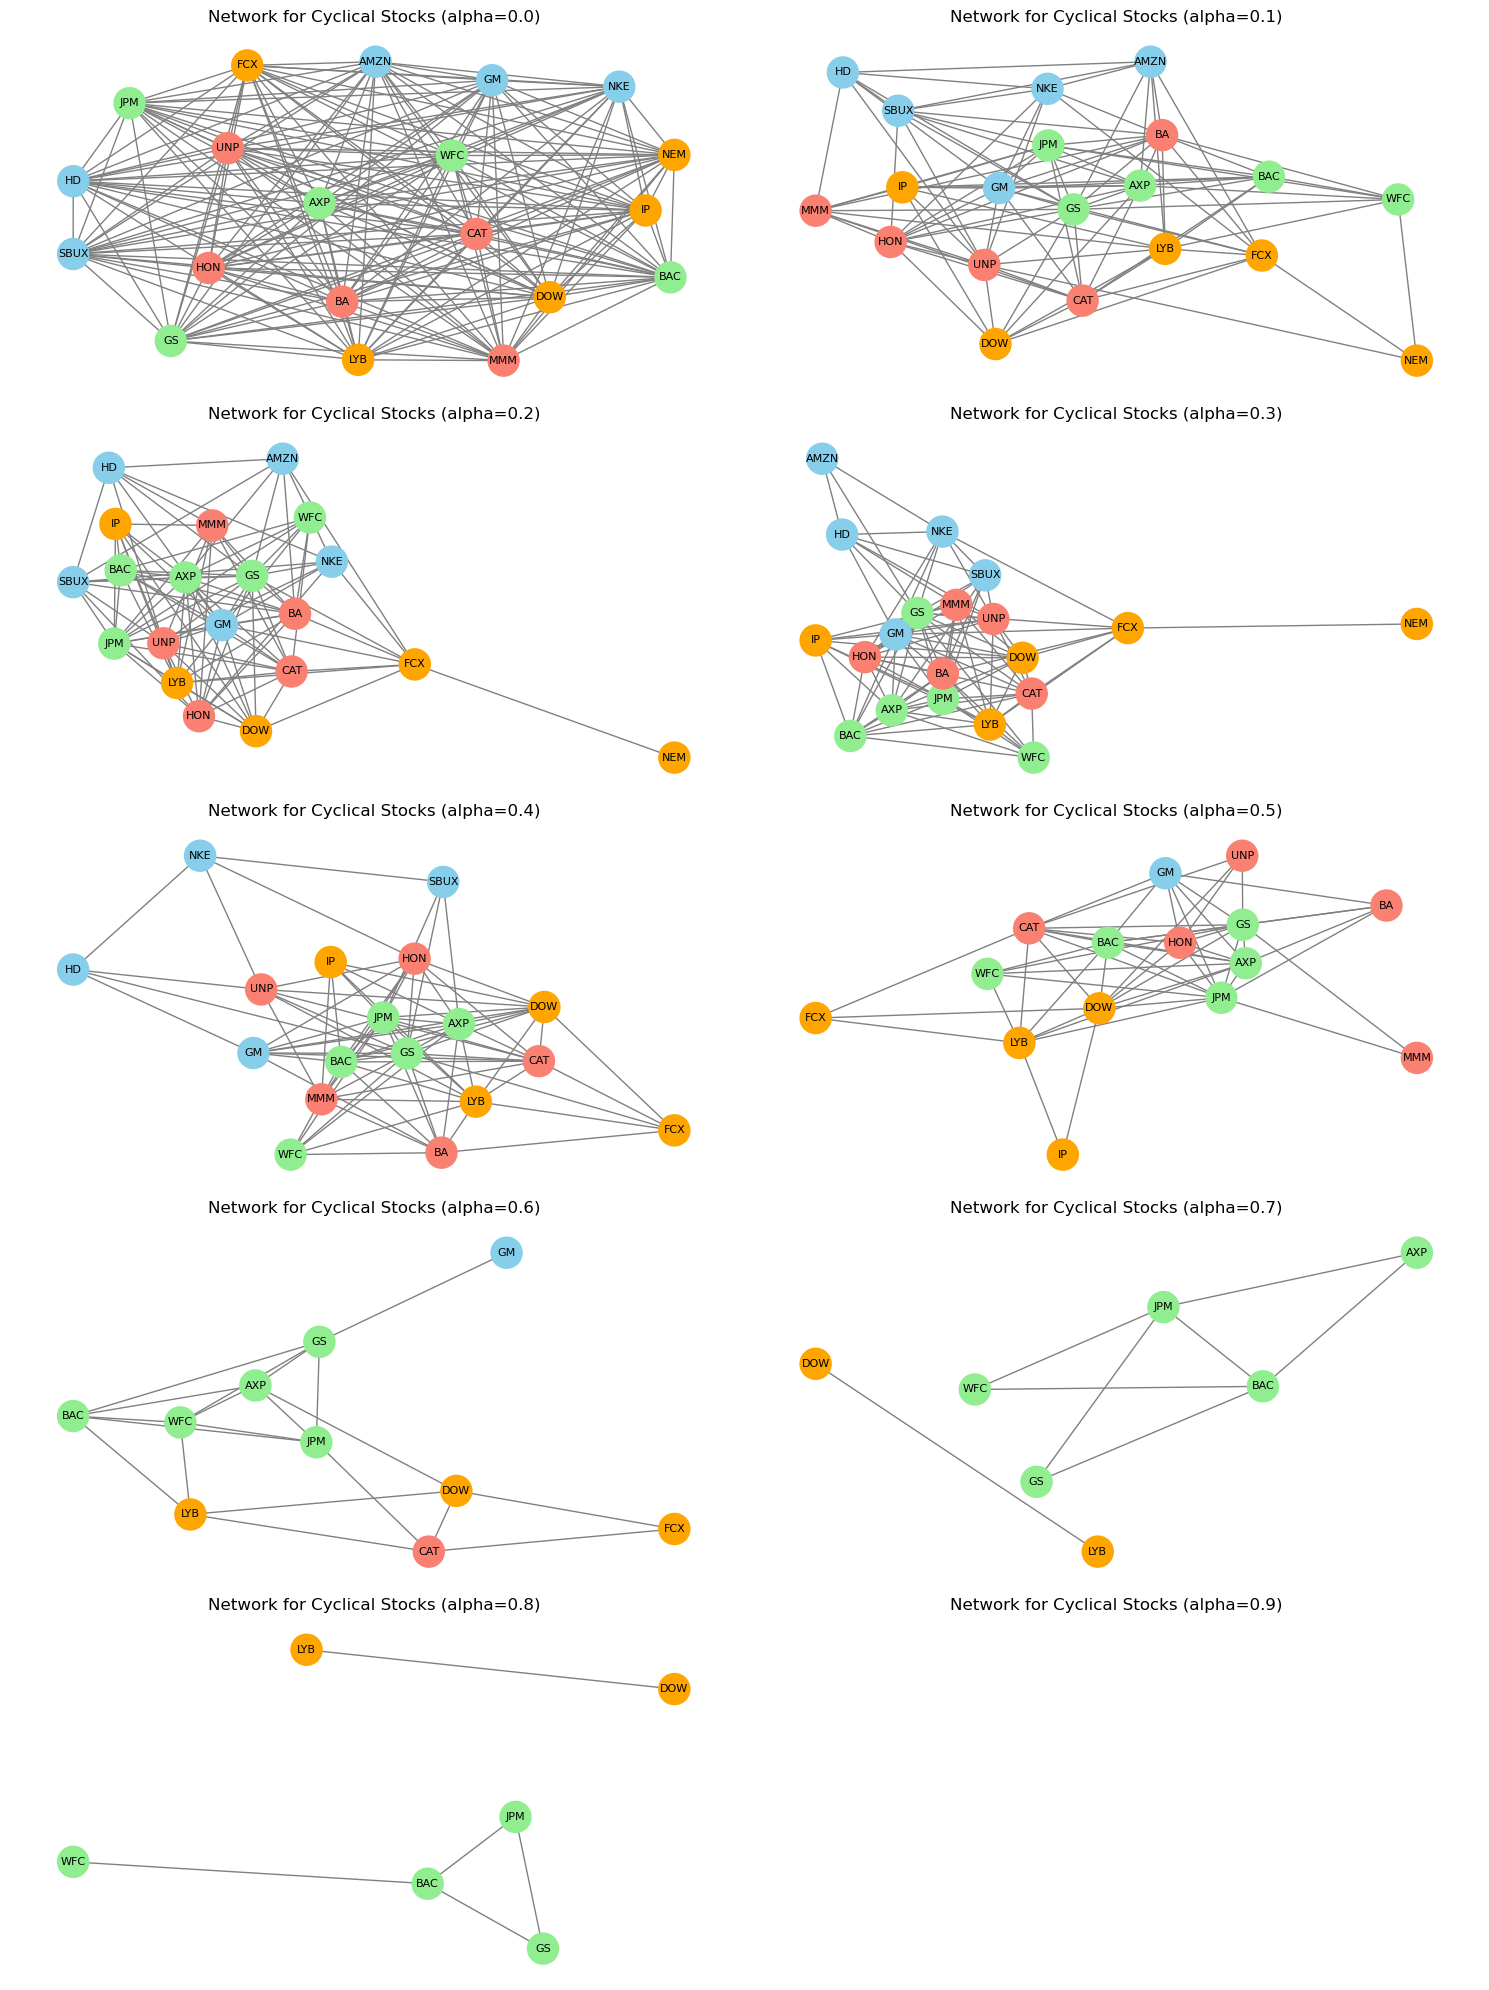

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
alpha_values = np.linspace(0, 0.9, 10)

for i, alpha in enumerate(alpha_values):
    glasso = GraphicalLasso(alpha=alpha).fit(X1)
    Omeghat = np.around(glasso.precision_, decimals=5)
    for j in np.arange(p1): 
        Omeghat[j, j] = 0
    precdf = pd.DataFrame(Omeghat, columns=cylical_stocks_names, index=cylical_stocks_names)
    links = precdf.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    links = links.loc[(abs(links['value']) > 0.01) & (links['var1'] != links['var2'])]
    G = nx.from_pandas_edgelist(links, 'var1', 'var2', create_using=nx.Graph())
    pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20, seed=42)
    node_colors = [sector_colors1[cyclical_sector_map[node]] for node in G.nodes]
    ax = axes[i // 2, i % 2]
    nx.draw(G, pos=pos, node_color=node_colors, with_labels=False, node_size=500, edge_color="gray", ax=ax)
    nx.draw_networkx_labels(G, pos=pos, font_size=8, ax=ax)
    ax.set_title(f'Network for Cyclical Stocks (alpha={alpha:.1f})')

plt.tight_layout()
plt.show()


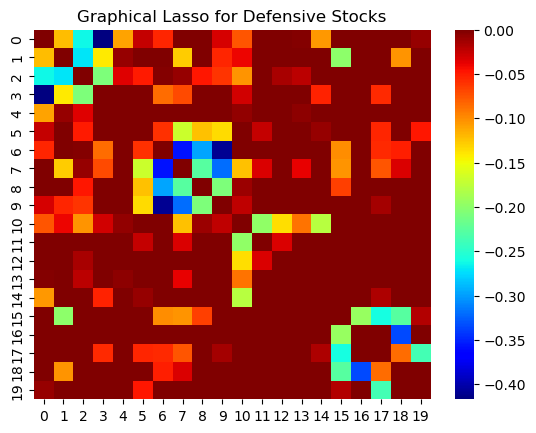

In [15]:
# Run the Graphical Lasso for Defensive Stocks 

X2 = np.array(clipped_defensive_log_returns)
p2 = X2.shape[1]
X2 = (X2 - np.mean(X1, axis=0)) / np.std(X2, axis=0)
glasso2 = GraphicalLasso(alpha=.3).fit(X2)
Omeghat2 = np.around(glasso2.precision_, decimals=5)

for j in np.arange(p2): 
    Omeghat2[j,j] = 0
sns.heatmap(Omeghat2, cmap='jet')
plt.title('Graphical Lasso for Defensive Stocks')
plt.show()

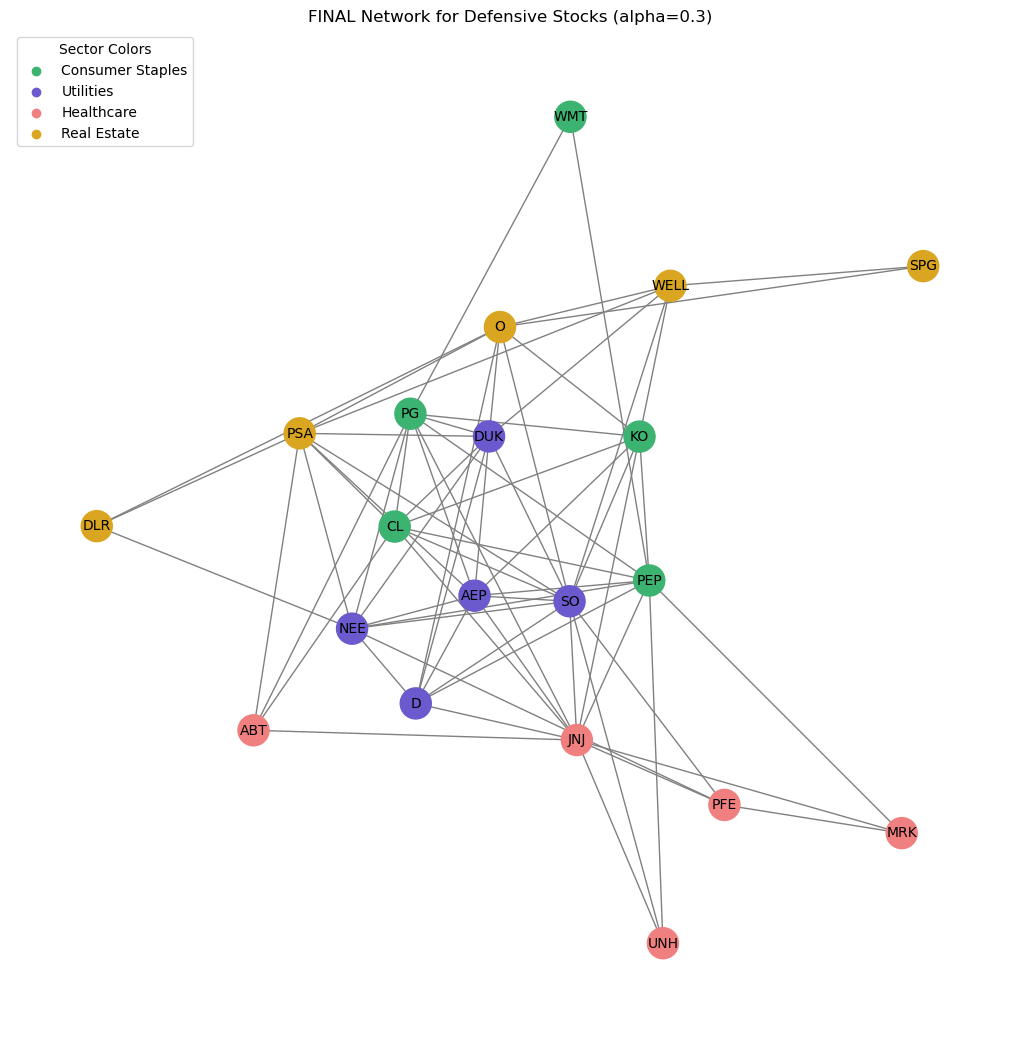

In [16]:
# Run the Graphical Lasso for Defensive Stocks
np.random.seed(42)

sector_colors2 = {
    "Consumer Staples": "mediumseagreen",
    "Utilities": "slateblue",
    "Healthcare": "lightcoral",
    "Real Estate": "goldenrod"
}


# Use stock symbols as node labels
defensive_stocks_names = list(defensive_stocks.keys())  
precdf2 = pd.DataFrame(Omeghat2, columns=defensive_stocks_names, index=defensive_stocks_names)

# Generate the links for the edges
links2 = precdf2.stack().reset_index()
links2.columns = ['var1', 'var2', 'value']
links2 = links2.loc[(abs(links2['value']) > 0.01) & (links2['var1'] != links2['var2'])]

# Build the graph using stock symbols
G2 = nx.from_pandas_edgelist(links2, 'var1', 'var2', create_using=nx.Graph())
pos2 = nx.spring_layout(G2, k=1.7/np.sqrt(len(G2.nodes())), iterations=20)

# Set colors for each node based on sector
node_colors2 = [sector_colors2[defensive_sector_map[node]] for node in G2.nodes]

# Visualize the Network for Cyclical Stocks with Colored Nodes
plt.figure(figsize=(10, 10))
nx.draw(G2, pos=pos2, node_color=node_colors2, with_labels=False, node_size=500, edge_color="gray")
nx.draw_networkx_labels(G2, pos=pos2, font_size=10)
plt.title('FINAL Network for Defensive Stocks (alpha=0.3)')
for sector, color in sector_colors2.items():
    plt.scatter([], [], color=color, label=sector)
plt.legend(loc="upper left", title="Sector Colors")
plt.show()

/var/folders/bf/76shnqyj7qz2pkgp1kh6r2hh0000gn/T/ipykernel_81055/2734056245.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20, seed=42)
/var/folders/bf/76shnqyj7qz2pkgp1kh6r2hh0000gn/T/ipykernel_81055/2734056245.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20, seed=42)


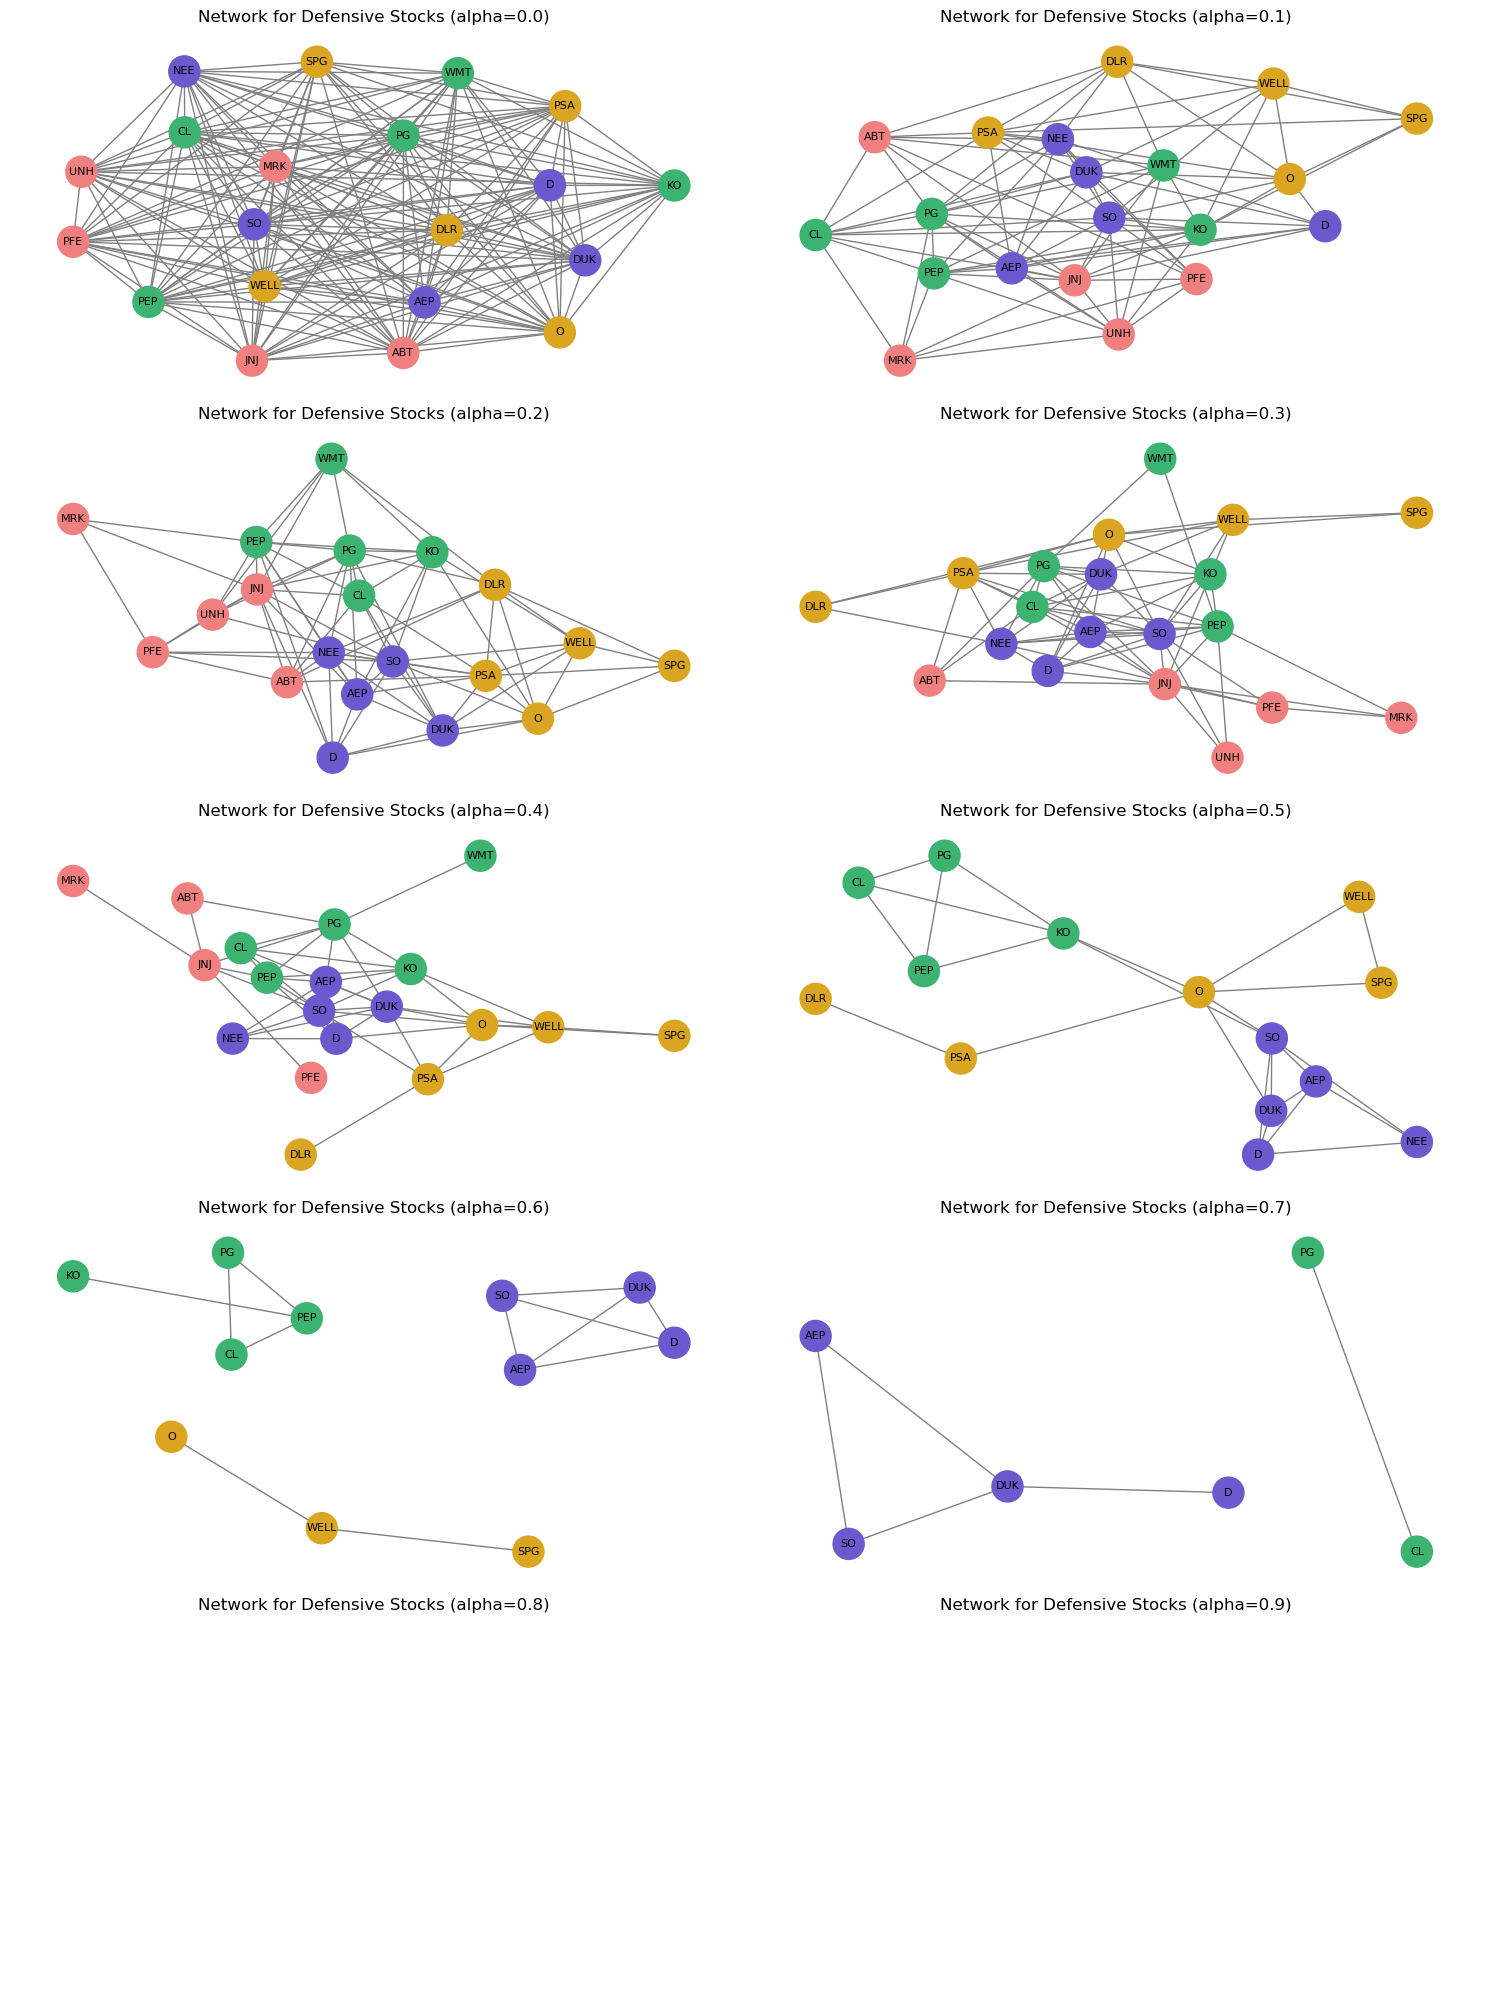

In [17]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
alpha_values = np.linspace(0, 0.9, 10)

for i, alpha in enumerate(alpha_values):
    glasso = GraphicalLasso(alpha=alpha).fit(X2)
    Omeghat = np.around(glasso.precision_, decimals=5)
    for j in np.arange(p2): 
        Omeghat[j, j] = 0
    precdf = pd.DataFrame(Omeghat, columns=defensive_stocks_names , index=defensive_stocks_names)
    links = precdf.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    links = links.loc[(abs(links['value']) > 0.01) & (links['var1'] != links['var2'])]
    G = nx.from_pandas_edgelist(links, 'var1', 'var2', create_using=nx.Graph())
    pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20, seed=42)
    node_colors = [sector_colors2[defensive_sector_map[node]] for node in G.nodes]
    ax = axes[i // 2, i % 2]
    nx.draw(G, pos=pos, node_color=node_colors, with_labels=False, node_size=500, edge_color="gray", ax=ax)
    nx.draw_networkx_labels(G, pos=pos, font_size=8, ax=ax)
    ax.set_title(f'Network for Defensive Stocks (alpha={alpha:.1f})')

plt.tight_layout()
plt.show()


### Report

I decided to construct two portfolios, each containing 20 stocks, that represent cylical and defensive sectors of the market. The first portfolio contains four sectors: Consumer Discretionary, Financials, Industrials, and Materials, all of which are known as "cylical" because they are highly influenced by current economy, and tend to rise in value during economic prosperity and fall during economic downturn. The second portfolio also contains four sectors: Consumer Staples, Utilities, Healthcare, and Real Estate, which are known as "defensive" because of their low volatility and consistent demand despite the economy. I chose five years of weekly data for each portfolio (i.e. starting five years before the week of this assignment) to get a sense of how cylical sectors are influencing each other in the present-day, and similarly with defensive sectors. 

I used a combination of strategies to choose the optimal regularization level in the glasso for each portfolio. In particular, I used cross-validation by plotting 10 graphs for each portfolio corresponding to regularization strengths lambda = 0.0 ... lambda = 0.9. I ended up selecting lambda = 0.3 for both portfolios. This was because the graphs associated with lambda = 0.3 featured meaningful connections while not becoming too parse (in particular, all of the nodes had at least one connection, which allows us to visualize various relationships between all of the stocks in the portfolios instead of a restricted subset). Most importantly, lambda=0.3 led to well-defined local clusters which provide a meaningful interpretation for analyzing my data. Given this regularization strength, the structure of the graphs makes a good deal of sense. Both of the graphs were quite sensitive to the choice of regularization level; a higher regulization caused nodes to not have any connections at all whereas a small regulization led to a graph that was almost fully connected. Detailed analysis for both is provided below. 

**Cyclical Portfolio**

There are well-defined clusters for all sectors in this graph, showing strong conditional dependencies between nodes in the same sectors. Additionally, sectors that are related on macroeconomic scales generally tend to be more related in the graph. For instance, Industrials and Materials share many connections, which is expected as both generally tend to strongly effect each other's performance. Consumer Discretionary and Industrials also feature numerous connections, which again makes sense as they rely strongly on each other. Conversely, Materials and Consumer Discretionary are not connected by many edges at all, following our intuition that materials focus on raw inputs instead of consumer end products. On the whole, however, there are many connections between stocks in different sectors. This is what I expected as these stocks all share the theme of being cylical and therefore should feature strong conditional dependence.

The graph implies many conditional independence assumptions, most of which make sense. For instance, although Amazon and Starbucks are both Consumer Discretionary, we would not expect them to be strongly related because they both sell distinct products that don't rely on each other. Indeed, there is no edge between AMZN and SBUX, showing that AMZN and SBUX are conditionally independent giving all of the other nodes in the graph. We also see that NEM (a gold mining company) is conditionally independent of all other stocks except for FCX, which is the only other company in the list that has gold mining operations. This validates our model and chosen form of regularization. Finally, we also see that certain regions of the graph are more densely connected than others. In particular, all of the Industrials stocks are strongly connected with other stocks whereas many of the Consumer Discretionary and Materials stocks feature fewer connections. This again makes intuitive sense as Industrials provides goods, services, and equipment used in all other sectors whereas Consumer Discretionary and Materials are slightly more isolated. 

**Defensive Portfolio**

We similarly see well-defined clusters in the graph for the defensive portfolio, showing strong conditional dependencies between nodes in the same sectors. Again, certain sectors seemed to be more related to others based off the graph. In particular, we see many connections between Real Estate and Utilities, which we would epect to see as utilities are instrumental to the operation and value of real estate. Conversely, we do not see many connections between Consumer Staples and Real Estate, which again makes intuitive sense. On the whole, while there are significant connections between sectors, there is a good deal of clustering in the graph, suggesting that some of the stocks are only marginally impacted by stocks in other sectors. This aligns with our intuition because defensive stocks generally tend to withstand widespread macroeconomic trends. 
